In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ensure results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# return directory
print(os.listdir('/kaggle/input/'))

['skin-cancer-mnist-ham10000']


In [2]:
print(os.listdir('../input/skin-cancer-mnist-ham10000'))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


# Load data

In [2]:
data_dir = '../input/skin-cancer-mnist-ham10000'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [3]:
# Values stored to save future run time
norm_mean = [0.7630392, 0.5456477, 0.57004845]
norm_std = [0.1409286, 0.15261266, 0.16997074]

In [4]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [5]:
# Determine how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# Filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [6]:
# Identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# Apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated


In [7]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [8]:
# Filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [9]:
# Create a val set using df as none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [10]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [11]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# Create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# Apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filter out training rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [12]:
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [13]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [14]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

# Split dataset

In [15]:
# Split the test set again in a validation set and a true test set:
df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [16]:
print(len(df_test))
df_test['cell_type'].value_counts()

552


Melanocytic nevi                  444
Benign keratosis-like lesions      47
dermatofibroma                     20
Basal cell carcinoma               15
Actinic keratoses                  12
Vascular lesions                    8
Dermatofibroma                      6
Name: cell_type, dtype: int64

# Set model

In [17]:
# feature_extract is a boolean that defines finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [19]:
model_name = "resnet"
num_classes = 7
feature_extract = False
# Initialize the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# device = torch.device('cpu') # If using cpu
# Put the model on the device:
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Data augmentation

In [22]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                     transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [23]:
# Define a pytorch dataloader for dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [24]:
# Define the training set using the table train_df and using the defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# Same for the test set:
test_set = HAM10000(df_test, transform=train_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

In [25]:
# set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [26]:
# this function is used during training process, to calculate the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [27]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [28]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [29]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1124], [train loss 1.67071], [train acc 0.36156]
[epoch 1], [iter 200 / 1124], [train loss 1.51895], [train acc 0.41734]
[epoch 1], [iter 300 / 1124], [train loss 1.42696], [train acc 0.45510]
[epoch 1], [iter 400 / 1124], [train loss 1.36015], [train acc 0.48320]
[epoch 1], [iter 500 / 1124], [train loss 1.30096], [train acc 0.50900]
[epoch 1], [iter 600 / 1124], [train loss 1.24955], [train acc 0.52938]
[epoch 1], [iter 700 / 1124], [train loss 1.20955], [train acc 0.54625]
[epoch 1], [iter 800 / 1124], [train loss 1.17708], [train acc 0.55922]
[epoch 1], [iter 900 / 1124], [train loss 1.14762], [train acc 0.57017]
[epoch 1], [iter 1000 / 1124], [train loss 1.12040], [train acc 0.58037]
[epoch 1], [iter 1100 / 1124], [train loss 1.09462], [train acc 0.59045]



0it [00:00, ?it/s]
1it [00:02,  2.36s/it]
3it [00:02,  1.48it/s]
5it [00:04,  1.37it/s]
7it [00:04,  2.20it/s]
8it [00:04,  2.66it/s]
9it [00:05,  1.65it/s]
11it [00:05,  2.55it/s]
13it [00:07,  1.93it/s]
15it [00:07,  2.74it/s]
18it [00:08,  2.16it/s]
 10%|█         | 1/10 [08:44<1:18:39, 524.37s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.43959], [val acc 0.85243]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.43959], [val acc 0.85243]
*****************************************************
[epoch 2], [iter 100 / 1124], [train loss 0.78675], [train acc 0.71281]
[epoch 2], [iter 200 / 1124], [train loss 0.77605], [train acc 0.71578]
[epoch 2], [iter 300 / 1124], [train loss 0.78844], [train acc 0.70833]
[epoch 2], [iter 400 / 1124], [train loss 0.77909], [train acc 0.71195]
[epoch 2], [iter 500 / 1124], [train loss 0.77660], [train acc 0.71144]
[epoch 2], [iter 600 / 1124], [train loss 0.76373], [train acc 0.71620]
[epoch 2], [iter 700 / 1124], [train loss 0.75496], [train acc 0.71826]
[epoch 2], [iter 800 / 1124], [train loss 0.74978], [train acc 0.72062]
[epoch 2], [iter 900 / 1124], [train loss 0.74213], [train acc 0.72333]
[epoch 2], 


0it [00:00, ?it/s]
1it [00:01,  1.71s/it]
3it [00:01,  1.97it/s]
5it [00:03,  1.64it/s]
7it [00:03,  2.57it/s]
9it [00:05,  1.67it/s]
10it [00:05,  1.96it/s]
11it [00:05,  2.27it/s]
13it [00:07,  1.79it/s]
15it [00:07,  2.62it/s]
18it [00:08,  2.25it/s]
 20%|██        | 2/10 [17:24<1:09:34, 521.86s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.63905], [val acc 0.76637]
------------------------------------------------------------
[epoch 3], [iter 100 / 1124], [train loss 0.66187], [train acc 0.74781]
[epoch 3], [iter 200 / 1124], [train loss 0.65413], [train acc 0.75547]
[epoch 3], [iter 300 / 1124], [train loss 0.63975], [train acc 0.75677]
[epoch 3], [iter 400 / 1124], [train loss 0.62647], [train acc 0.76125]
[epoch 3], [iter 500 / 1124], [train loss 0.62480], [train acc 0.76138]
[epoch 3], [iter 600 / 1124], [train loss 0.61806], [train acc 0.76568]
[epoch 3], [iter 700 / 1124], [train loss 0.60691], [train acc 0.77098]
[epoch 3], [iter 800 / 1124], [train loss 0.60426], [train acc 0.77219]
[epoch 3], [iter 900 / 1124], [train loss 0.59682], [train acc 0.77517]
[epoch 3], [iter 1000 / 1124], [train loss 0.59158], [train acc 0.77772]
[epoch 3], [iter 1100 / 1124], [train loss 0.58846], [train acc 0.77898]



0it [00:00, ?it/s]
1it [00:01,  1.76s/it]
3it [00:01,  1.93it/s]
5it [00:03,  1.47it/s]
6it [00:03,  1.90it/s]
7it [00:03,  2.44it/s]
9it [00:05,  1.83it/s]
11it [00:05,  2.68it/s]
13it [00:06,  2.06it/s]
15it [00:06,  2.90it/s]
18it [00:07,  2.36it/s]
 30%|███       | 3/10 [26:03<1:00:43, 520.52s/it]

------------------------------------------------------------
[epoch 3], [val loss 0.39348], [val acc 0.85590]
------------------------------------------------------------
*****************************************************
best record: [epoch 3], [val loss 0.39348], [val acc 0.85590]
*****************************************************
[epoch 4], [iter 100 / 1124], [train loss 0.48886], [train acc 0.81563]
[epoch 4], [iter 200 / 1124], [train loss 0.51154], [train acc 0.80906]
[epoch 4], [iter 300 / 1124], [train loss 0.51402], [train acc 0.80583]
[epoch 4], [iter 400 / 1124], [train loss 0.52348], [train acc 0.80023]
[epoch 4], [iter 500 / 1124], [train loss 0.52134], [train acc 0.80144]
[epoch 4], [iter 600 / 1124], [train loss 0.52076], [train acc 0.80094]
[epoch 4], [iter 700 / 1124], [train loss 0.51915], [train acc 0.80232]
[epoch 4], [iter 800 / 1124], [train loss 0.51415], [train acc 0.80453]
[epoch 4], [iter 900 / 1124], [train loss 0.51147], [train acc 0.80507]
[epoch 4], 


0it [00:00, ?it/s]
1it [00:01,  1.89s/it]
2it [00:02,  1.18it/s]
3it [00:02,  1.97it/s]
5it [00:03,  1.70it/s]
6it [00:03,  2.12it/s]
8it [00:03,  3.37it/s]
9it [00:05,  1.90it/s]
10it [00:05,  2.24it/s]
12it [00:05,  3.43it/s]
13it [00:06,  1.94it/s]
14it [00:06,  2.36it/s]
16it [00:06,  3.64it/s]
18it [00:07,  2.41it/s]
 40%|████      | 4/10 [34:41<51:58, 519.75s/it]  

------------------------------------------------------------
[epoch 4], [val loss 0.60235], [val acc 0.79762]
------------------------------------------------------------
[epoch 5], [iter 100 / 1124], [train loss 0.44517], [train acc 0.82719]
[epoch 5], [iter 200 / 1124], [train loss 0.44394], [train acc 0.83453]
[epoch 5], [iter 300 / 1124], [train loss 0.45473], [train acc 0.82937]
[epoch 5], [iter 400 / 1124], [train loss 0.44372], [train acc 0.83305]
[epoch 5], [iter 500 / 1124], [train loss 0.44812], [train acc 0.83213]
[epoch 5], [iter 600 / 1124], [train loss 0.44275], [train acc 0.83380]
[epoch 5], [iter 700 / 1124], [train loss 0.44186], [train acc 0.83330]
[epoch 5], [iter 800 / 1124], [train loss 0.44120], [train acc 0.83289]
[epoch 5], [iter 900 / 1124], [train loss 0.43693], [train acc 0.83375]
[epoch 5], [iter 1000 / 1124], [train loss 0.43713], [train acc 0.83397]
[epoch 5], [iter 1100 / 1124], [train loss 0.43748], [train acc 0.83398]



0it [00:00, ?it/s]
1it [00:01,  1.78s/it]
3it [00:01,  1.91it/s]
5it [00:03,  1.58it/s]
7it [00:03,  2.51it/s]
9it [00:04,  1.95it/s]
11it [00:05,  2.74it/s]
13it [00:06,  2.15it/s]
15it [00:06,  2.97it/s]
18it [00:07,  2.50it/s]
 50%|█████     | 5/10 [43:21<43:19, 519.82s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.39599], [val acc 0.85417]
------------------------------------------------------------
[epoch 6], [iter 100 / 1124], [train loss 0.38775], [train acc 0.84937]
[epoch 6], [iter 200 / 1124], [train loss 0.40960], [train acc 0.84359]
[epoch 6], [iter 300 / 1124], [train loss 0.40877], [train acc 0.84344]
[epoch 6], [iter 400 / 1124], [train loss 0.40887], [train acc 0.84352]
[epoch 6], [iter 500 / 1124], [train loss 0.40630], [train acc 0.84294]
[epoch 6], [iter 600 / 1124], [train loss 0.40302], [train acc 0.84401]
[epoch 6], [iter 700 / 1124], [train loss 0.40298], [train acc 0.84379]
[epoch 6], [iter 800 / 1124], [train loss 0.39737], [train acc 0.84566]
[epoch 6], [iter 900 / 1124], [train loss 0.39568], [train acc 0.84681]
[epoch 6], [iter 1000 / 1124], [train loss 0.39284], [train acc 0.84778]
[epoch 6], [iter 1100 / 1124], [train loss 0.39017], [train acc 0.84841]



0it [00:00, ?it/s]
1it [00:01,  1.62s/it]
2it [00:01,  1.18it/s]
3it [00:02,  1.86it/s]
4it [00:02,  2.53it/s]
5it [00:03,  1.30it/s]
6it [00:03,  1.69it/s]
8it [00:04,  2.90it/s]
9it [00:05,  1.52it/s]
10it [00:05,  1.91it/s]
12it [00:06,  2.98it/s]
13it [00:07,  1.71it/s]
15it [00:07,  2.62it/s]
18it [00:08,  2.19it/s]
 60%|██████    | 6/10 [52:04<34:42, 520.72s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.44647], [val acc 0.85069]
------------------------------------------------------------
[epoch 7], [iter 100 / 1124], [train loss 0.33824], [train acc 0.87187]
[epoch 7], [iter 200 / 1124], [train loss 0.33447], [train acc 0.87000]
[epoch 7], [iter 300 / 1124], [train loss 0.34940], [train acc 0.86552]
[epoch 7], [iter 400 / 1124], [train loss 0.35003], [train acc 0.86555]
[epoch 7], [iter 500 / 1124], [train loss 0.35678], [train acc 0.86313]
[epoch 7], [iter 600 / 1124], [train loss 0.34993], [train acc 0.86594]
[epoch 7], [iter 700 / 1124], [train loss 0.34690], [train acc 0.86741]
[epoch 7], [iter 800 / 1124], [train loss 0.34685], [train acc 0.86730]
[epoch 7], [iter 900 / 1124], [train loss 0.34627], [train acc 0.86753]
[epoch 7], [iter 1000 / 1124], [train loss 0.34707], [train acc 0.86794]
[epoch 7], [iter 1100 / 1124], [train loss 0.34825], [train acc 0.86759]



0it [00:00, ?it/s]
1it [00:01,  1.83s/it]
3it [00:02,  1.86it/s]
5it [00:03,  1.55it/s]
7it [00:03,  2.42it/s]
9it [00:05,  1.84it/s]
10it [00:05,  2.16it/s]
11it [00:05,  2.52it/s]
12it [00:05,  3.07it/s]
13it [00:07,  1.59it/s]
15it [00:07,  2.55it/s]
18it [00:07,  2.28it/s]
 70%|███████   | 7/10 [1:00:45<26:02, 520.86s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.40779], [val acc 0.85764]
------------------------------------------------------------
*****************************************************
best record: [epoch 7], [val loss 0.40779], [val acc 0.85764]
*****************************************************
[epoch 8], [iter 100 / 1124], [train loss 0.30284], [train acc 0.88219]
[epoch 8], [iter 200 / 1124], [train loss 0.30542], [train acc 0.88266]
[epoch 8], [iter 300 / 1124], [train loss 0.30747], [train acc 0.88187]
[epoch 8], [iter 400 / 1124], [train loss 0.30964], [train acc 0.88062]
[epoch 8], [iter 500 / 1124], [train loss 0.30813], [train acc 0.88200]
[epoch 8], [iter 600 / 1124], [train loss 0.30144], [train acc 0.88474]
[epoch 8], [iter 700 / 1124], [train loss 0.30611], [train acc 0.88366]
[epoch 8], [iter 800 / 1124], [train loss 0.30823], [train acc 0.88199]
[epoch 8], [iter 900 / 1124], [train loss 0.30943], [train acc 0.88101]
[epoch 8], 


0it [00:00, ?it/s]
1it [00:01,  1.69s/it]
3it [00:01,  1.98it/s]
5it [00:03,  1.69it/s]
7it [00:03,  2.63it/s]
9it [00:04,  1.96it/s]
11it [00:05,  2.73it/s]
13it [00:06,  2.12it/s]
15it [00:06,  2.92it/s]
18it [00:07,  2.50it/s]
 80%|████████  | 8/10 [1:09:23<17:19, 520.00s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.42649], [val acc 0.88368]
------------------------------------------------------------
*****************************************************
best record: [epoch 8], [val loss 0.42649], [val acc 0.88368]
*****************************************************
[epoch 9], [iter 100 / 1124], [train loss 0.26681], [train acc 0.89750]
[epoch 9], [iter 200 / 1124], [train loss 0.28456], [train acc 0.89234]
[epoch 9], [iter 300 / 1124], [train loss 0.28605], [train acc 0.89240]
[epoch 9], [iter 400 / 1124], [train loss 0.28377], [train acc 0.89281]
[epoch 9], [iter 500 / 1124], [train loss 0.28172], [train acc 0.89312]
[epoch 9], [iter 600 / 1124], [train loss 0.28351], [train acc 0.89141]
[epoch 9], [iter 700 / 1124], [train loss 0.28676], [train acc 0.89080]
[epoch 9], [iter 800 / 1124], [train loss 0.28608], [train acc 0.89156]
[epoch 9], [iter 900 / 1124], [train loss 0.28343], [train acc 0.89187]
[epoch 9], 


0it [00:00, ?it/s]
1it [00:01,  1.57s/it]
2it [00:01,  1.37it/s]
4it [00:01,  3.08it/s]
5it [00:03,  1.55it/s]
7it [00:03,  2.62it/s]
9it [00:04,  1.97it/s]
11it [00:05,  2.79it/s]
13it [00:06,  2.17it/s]
15it [00:06,  2.82it/s]
18it [00:07,  2.44it/s]
 90%|█████████ | 9/10 [1:18:03<08:39, 519.80s/it]

------------------------------------------------------------
[epoch 9], [val loss 0.47329], [val acc 0.85069]
------------------------------------------------------------
[epoch 10], [iter 100 / 1124], [train loss 0.23296], [train acc 0.90781]
[epoch 10], [iter 200 / 1124], [train loss 0.23931], [train acc 0.90781]
[epoch 10], [iter 300 / 1124], [train loss 0.24999], [train acc 0.90396]
[epoch 10], [iter 400 / 1124], [train loss 0.25598], [train acc 0.90125]
[epoch 10], [iter 500 / 1124], [train loss 0.25670], [train acc 0.90156]
[epoch 10], [iter 600 / 1124], [train loss 0.25729], [train acc 0.90208]
[epoch 10], [iter 700 / 1124], [train loss 0.26279], [train acc 0.90031]
[epoch 10], [iter 800 / 1124], [train loss 0.26221], [train acc 0.90059]
[epoch 10], [iter 900 / 1124], [train loss 0.25793], [train acc 0.90215]
[epoch 10], [iter 1000 / 1124], [train loss 0.25548], [train acc 0.90269]
[epoch 10], [iter 1100 / 1124], [train loss 0.25473], [train acc 0.90261]



0it [00:00, ?it/s]
1it [00:01,  1.64s/it]
3it [00:01,  2.03it/s]
5it [00:03,  1.68it/s]
6it [00:03,  2.12it/s]
7it [00:03,  2.65it/s]
8it [00:03,  3.28it/s]
9it [00:05,  1.37it/s]
10it [00:05,  1.83it/s]
12it [00:05,  2.99it/s]
13it [00:07,  1.57it/s]
14it [00:07,  1.96it/s]
16it [00:07,  3.10it/s]
18it [00:08,  2.24it/s]
100%|██████████| 10/10 [1:26:41<00:00, 520.17s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.46001], [val acc 0.88021]
------------------------------------------------------------


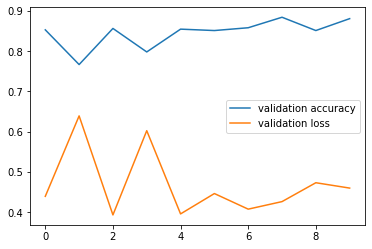

In [30]:
fig = plt.figure(num = 1)
fig2 = fig.add_subplot(1,1,1)
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.plot(total_loss_val, label = 'validation loss')

plt.legend()
plt.show()

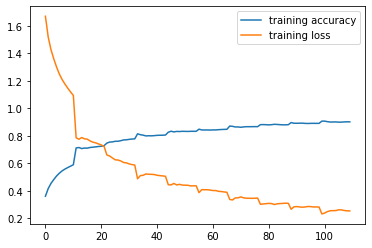

In [31]:
fig = plt.figure(num=1)
fig1 = fig.add_subplot(1,1,1)
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_train, label = 'training loss')

plt.legend()
plt.show()

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

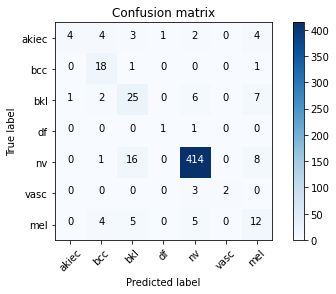

In [33]:
# Validation data evaluation

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

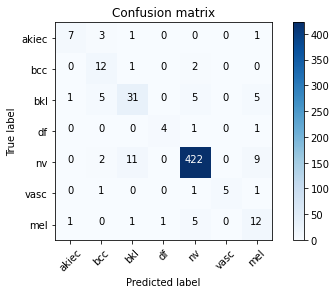

In [38]:
# Test data evaluation

model.eval()
test_y_label = []
test_y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        test_y_label.extend(labels.cpu().numpy())
        test_y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx_test = confusion_matrix(test_y_label, test_y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [36]:
# Generate a validation classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.80      0.22      0.35        18
         bcc       0.62      0.90      0.73        20
         bkl       0.50      0.61      0.55        41
          df       0.50      0.50      0.50         2
          nv       0.96      0.94      0.95       439
        vasc       1.00      0.40      0.57         5
         mel       0.38      0.46      0.41        26

    accuracy                           0.86       551
   macro avg       0.68      0.58      0.58       551
weighted avg       0.88      0.86      0.86       551



In [37]:
# Generate a test classification report
report = classification_report(test_y_label, test_y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.78      0.58      0.67        12
         bcc       0.52      0.80      0.63        15
         bkl       0.69      0.66      0.67        47
          df       0.80      0.67      0.73         6
          nv       0.97      0.95      0.96       444
        vasc       1.00      0.62      0.77         8
         mel       0.41      0.60      0.49        20

    accuracy                           0.89       552
   macro avg       0.74      0.70      0.70       552
weighted avg       0.91      0.89      0.90       552



Text(0, 0.5, 'Fraction classified incorrectly')

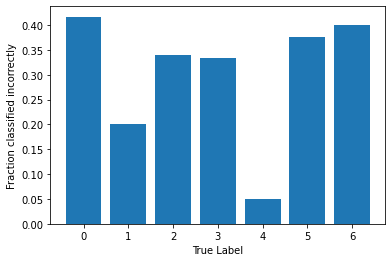

In [39]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

Text(0, 0.5, 'Fraction classified incorrectly')

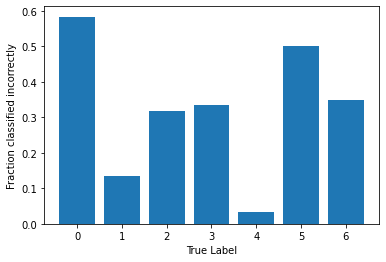

In [40]:
label_frac_error = 1 - np.diag(confusion_mtx_test) / np.sum(confusion_mtx_test, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')